<a href="https://colab.research.google.com/github/simjeongho/XceptionV2/blob/main/WGan_6464Scratch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import functools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm
import time
from IPython import display
from tensorflow import keras 
from tensorflow.keras.layers import *
from pathlib import Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = Path('/content/drive/MyDrive/data_64_all/scratch/2/')
len(os.listdir(path))

60

In [4]:
img_fn = [str(path/fn) for fn in os.listdir(path)]

In [5]:
dataset = tf.data.Dataset.from_tensor_slices(img_fn)
print(dataset)

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [6]:
import cv2
def preprocess(fn):
    img = tf.io.read_file(fn)
    img = tf.image.decode_jpeg(img, 3)
    img = tf.cast(img, dtype=tf.float32)
    #img = (img - 127.5) / 127.5
    img = img / 255
    img = tf.image.resize(img, (64, 64))
    return img

In [7]:
TOTAL=60
BATCH_SIZE=8

In [8]:
dataset = dataset.map(preprocess, num_parallel_calls=-1).cache()

In [9]:
dataset = dataset.shuffle(TOTAL).batch(BATCH_SIZE, drop_remainder=True)

In [10]:
dataset = dataset.prefetch(32)

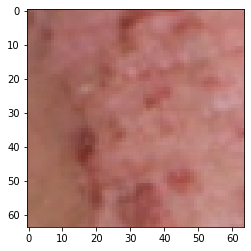

In [11]:
plt.imshow(next(dataset.as_numpy_iterator())[3])

In [12]:
next(dataset.as_numpy_iterator())[:BATCH_SIZE].shape

(8, 64, 64, 3)

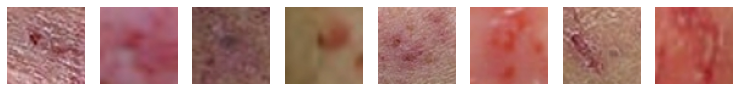

In [13]:
def show(images):
    fig, ax = plt.subplots(1, BATCH_SIZE, figsize=(13, 13))
    for i, a in enumerate(ax):
        a.imshow(np.squeeze(images[i]))
        a.axis('off')
    plt.show()
show(next(dataset.as_numpy_iterator())[:BATCH_SIZE])

In [14]:
class ConvLayer(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv = Conv2D(nf, ks, strides=strides, padding=padding,
                           kernel_initializer='he_normal', kernel_constraint=constraint, use_bias=False)
#         self.bn = BatchNormalization()
        self.norm = LayerNormalization()
        self.act = LeakyReLU(0.2)
        
    def call(self, X):
        X = self.act(self.conv(X))
        return self.norm(X)
    
def conv_layer(nf, ks, strides=2, padding='same'):
    conv = Conv2D(nf, ks, strides=strides, padding=padding, use_bias=False)
    bn = BatchNormalization()
    act = LeakyReLU(0.2)
    return keras.Sequential([conv, act, bn])

In [15]:
def critic(input_shape=(64, 64, 3), dim=64, n_downsamplings=4):
    h = inputs = keras.Input(shape=input_shape)
    # 1: downsamplings, ... -> 16x16 -> 8x8 -> 4x4
    h = ConvLayer(dim, 4, strides=2, padding='same')(h)
    for i in range(n_downsamplings - 1):
        d = min(dim * 2 ** (i + 1), dim * 8)
        h = ConvLayer(d, 4, strides=2, padding='same')(h)

    h = keras.layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer='he_normal')(h)
    h = Flatten()(h)
    return keras.Model(inputs=inputs, outputs=h)

In [16]:
d = critic()
d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv_layer (ConvLayer)      (None, 32, 32, 64)        3200      
                                                                 
 conv_layer_1 (ConvLayer)    (None, 16, 16, 128)       131328    
                                                                 
 conv_layer_2 (ConvLayer)    (None, 8, 8, 256)         524800    
                                                                 
 conv_layer_3 (ConvLayer)    (None, 4, 4, 512)         2098176   
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 1)           8193      
                                                                 
 flatten (Flatten)           (None, 1)                 0     

In [17]:
class UpsampleBlock(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding, 
                                              kernel_initializer='he_normal', kernel_constraint=constraint)
#         self.bn = BatchNormalization()
        self.norm = LayerNormalization()
        self.act = ReLU()
        
    def call(self, X):
        X = self.act(self.conv_transpose(X))
        return self.norm(X)
    
def deconv_layer( nf, ks, strides=2, padding='same'):
    conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding)
    bn = BatchNormalization()
    act = ReLU()
    return keras.Sequential([conv_transpose, act, bn])

In [18]:
def generator(input_shape=(1, 1, 128), output_channels=3, dim=64, n_upsamplings=4):
    h = inputs = keras.Input(shape=input_shape)
    d = min(dim * 2 ** (n_upsamplings - 1), dim * 8)
    h = UpsampleBlock(d, 4, strides=1, padding='valid')(h)
    
    #  upsamplings, 4x4 -> 8x8 -> 16x16 -> ...
    for i in range(n_upsamplings - 1):
        d = min(dim * 2 ** (n_upsamplings - 2 - i), dim * 8)
        h = UpsampleBlock(d, 4, strides=2, padding='same')(h)
        
    h = keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                     kernel_initializer='he_normal')(h)
    h = keras.layers.Activation('tanh')(h)

    return keras.Model(inputs=inputs, outputs=h)

In [19]:
g = generator()
g.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 128)]       0         
                                                                 
 upsample_block (UpsampleBlo  (None, 4, 4, 512)        1050112   
 ck)                                                             
                                                                 
 upsample_block_1 (UpsampleB  (None, 8, 8, 256)        2097920   
 lock)                                                           
                                                                 
 upsample_block_2 (UpsampleB  (None, 16, 16, 128)      524672    
 lock)                                                           
                                                                 
 upsample_block_3 (UpsampleB  (None, 32, 32, 64)       131264    
 lock)                                                     

In [20]:
#Wasserstein loss
def d_loss(real, fake):
    real_loss = -tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
#     real_lbl = tf.ones_like(real)
#     fake_lbl = tf.zeros_like(fake)
#     real_loss = tf.losses.binary_crossentropy(real_lbl, real)
#     fake_loss = tf.losses.binary_crossentropy(fake_lbl, fake)
    return real_loss + fake_loss

def g_loss(fake):
#     return tf.losses.binary_crossentropy(tf.ones_like(fake), fake)
    return - tf.reduce_mean(fake)

In [21]:
@tf.function
def gradient_penalty(model, real, fake):
    shape = [tf.shape(real)[0]] + [1, 1, 1]
    alpha = tf.random.uniform(shape=shape, minval=0, maxval=1)
    interpolated = alpha * real  + (1-alpha) * fake
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = model(interpolated)
    grad = tape.gradient(pred, interpolated)
    norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [22]:
EPOCHS = 10
noise_dim = 128

In [23]:
optD = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)
optG = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
@tf.function
def trainD(real):
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        fake_images = g(noise, training=True)
        real_output = d(real, training=True)
        fake_output = d(fake_images, training=True)
        gp_loss = gradient_penalty(functools.partial(d, training=True), real, fake_images)
        loss = d_loss(real_output, fake_output)
        disc_loss = loss + 10 * gp_loss
        
    d_grad = tape.gradient(disc_loss, d.trainable_variables)
    optD.apply_gradients(zip(d_grad, d.trainable_variables))
    
    
@tf.function
def trainG():
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        generated_images = g(noise, training=True)
        loss = g_loss(d(generated_images))
        
    g_grad = tape.gradient(loss, g.trainable_variables)
    optG.apply_gradients(zip(g_grad, g.trainable_variables))

In [25]:
seed = tf.random.normal((16, 1, 1, 128))

In [26]:
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig, ax = plt.subplots(4, 4, figsize=(10,10))

    for i, a in enumerate(ax.flat):
        a.imshow(predictions[i, :, :, :])
        a.axis('off')
    plt.show()

In [27]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in tqdm.tqdm(dataset, total=TOTAL//BATCH_SIZE):
          # train_step(image_batch)
            trainD(image_batch)
            if optD.iterations.numpy() % 5 == 0:
                trainG()

        display.clear_output(wait=True)
        generate_images(g, epoch + 1, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

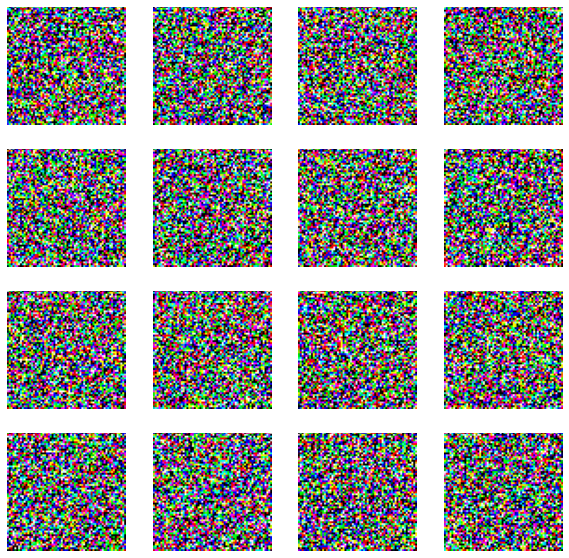

Time for epoch 1 is 21.30515480041504 sec


In [28]:
train(dataset, 1)
# 1 epochs

In [ ]:
train(dataset, 100)

In [ ]:
train(dataset, 1000)

In [ ]:
train(dataset, 1000)

In [ ]:
train(dataset, 5000)

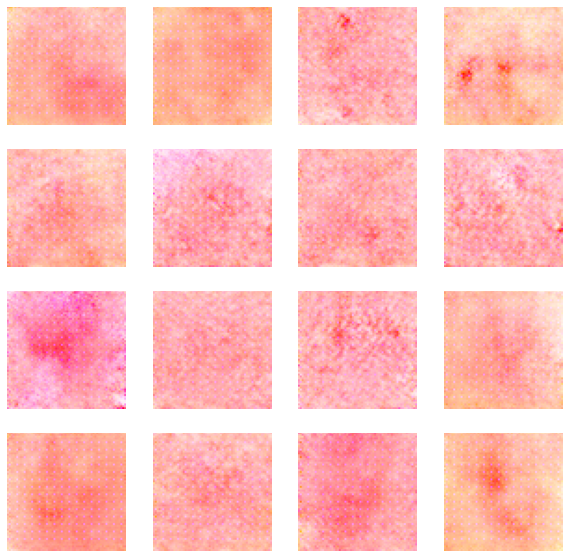

Time for epoch 4952 is 1.0611789226531982 sec


100%|██████████| 7/7 [00:00<00:00, 31.16it/s]


In [ ]:
train(dataset, 5000)

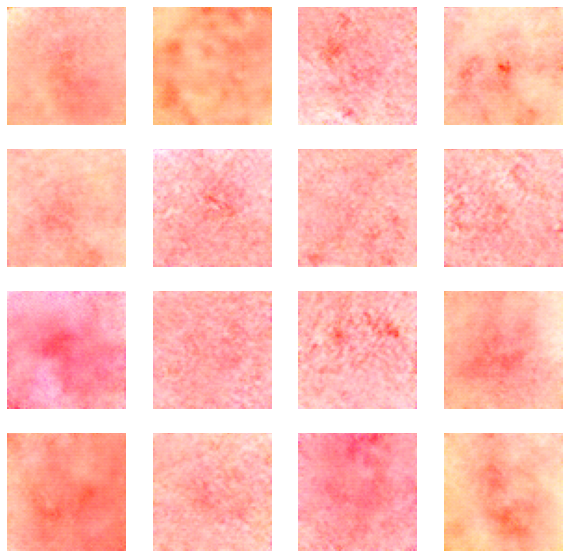

Time for epoch 4984 is 0.9748554229736328 sec


100%|██████████| 7/7 [00:00<00:00, 31.62it/s]


In [ ]:
train(dataset, 5000)

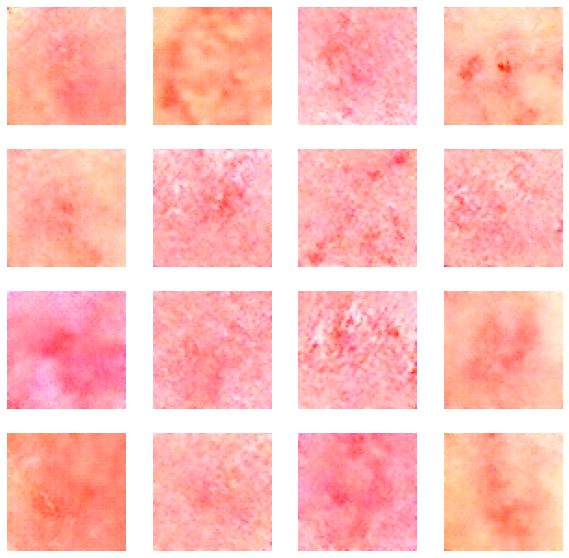

Time for epoch 5000 is 0.868675708770752 sec


In [35]:
train(dataset, 5000)

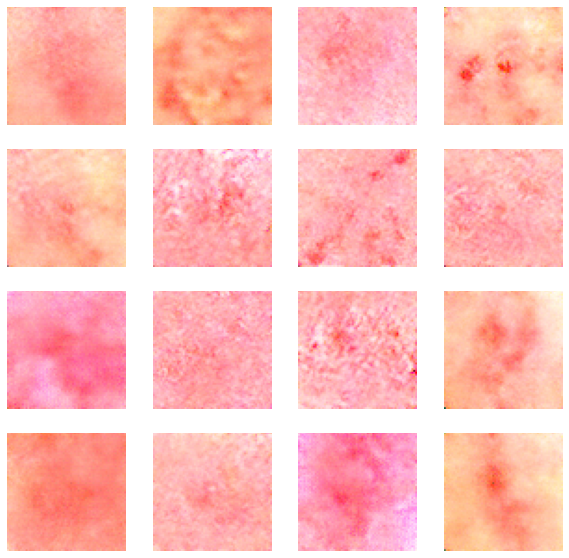

Time for epoch 5000 is 1.0187675952911377 sec


In [36]:
train(dataset, 5000)

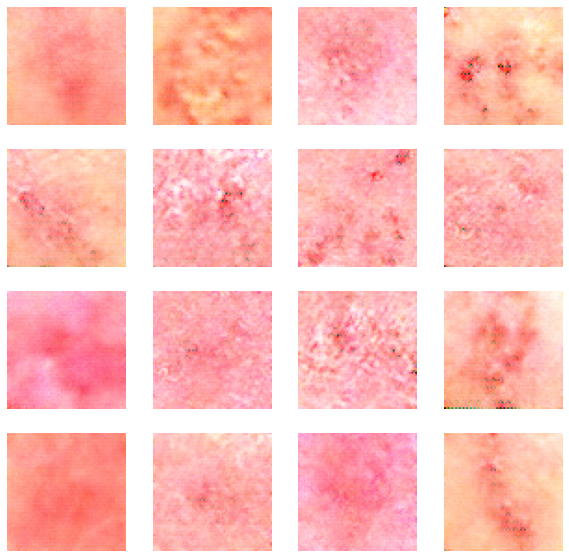

Time for epoch 4887 is 0.906214714050293 sec


 57%|█████▋    | 4/7 [00:00<00:00, 32.77it/s]

In [ ]:
train(dataset, 5000)

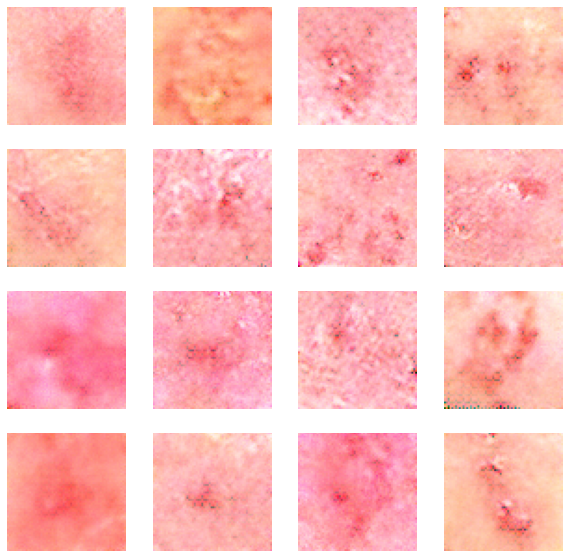

Time for epoch 4939 is 0.9135868549346924 sec


  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
train(dataset, 5000)

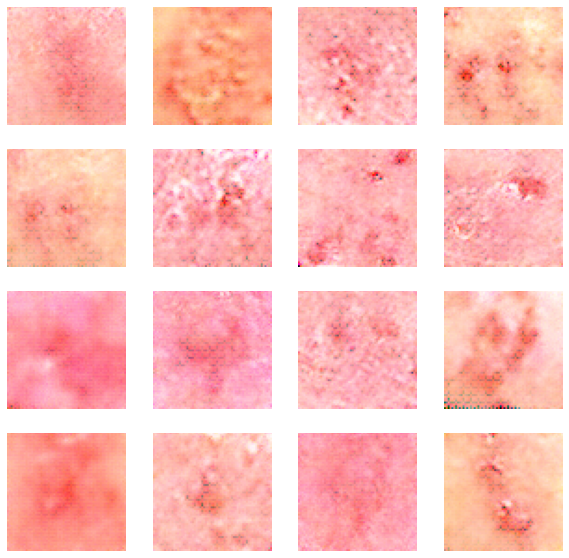

Time for epoch 5000 is 1.0198864936828613 sec


In [39]:
train(dataset, 5000)

In [ ]:
train(dataset, 5000)

In [ ]:
train(dataset, 5000)

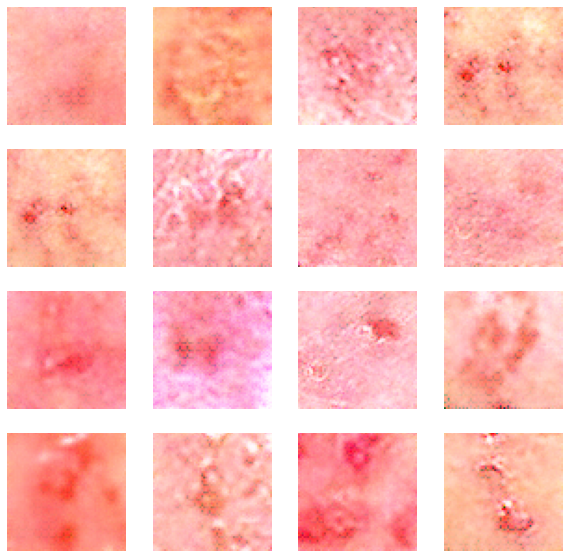

Time for epoch 5000 is 1.0790505409240723 sec


In [42]:
train(dataset, 5000)

In [ ]:
train(dataset, 5000)

In [ ]:
import numpy as np
from tifffile import imsave
from PIL import Image

In [ ]:
def saved_images(model, epoch, test_input, index):
    predictions = model(test_input, training=False)
    for j in range(16):
        image = predictions[j] * 255
        image = np.array(image, dtype=np.uint8)
        image = Image.fromarray(image)
        image.save('/content/drive/MyDrive/generatedScratch2/myScratch2_'+str(index+j)+'.jpg')

In [46]:
for i in range(150):
  saved_images(g, 1, tf.random.normal([16, 1, 1, 128]),i*16)

In [54]:
def saved_images1(model, epoch, test_input, index):
    predictions = model(test_input, training=False)
    for j in range(16):
        image = predictions[j] * 255
        image = np.array(image, dtype=np.uint8)
        image = Image.fromarray(image)
        image.save('/content/drive/MyDrive/data_64_2/긁은 상처/generatedScratch2/myScratch2_'+str(index+j)+'.jpg')

In [55]:
for i in range(150):
  saved_images1(g, 1, tf.random.normal([16, 1, 1, 128]),i*16)